<a href="https://colab.research.google.com/github/cagatayeskin/Data-Fitting-with-ANNs/blob/main/Data_with_Asymmetric_Errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Fitting a Linear Model to Data with Asymmetric Errors in Both Coordinates***

## **Creating data with log-normally distributed errors**

We generate errors on data points using log-normal distribution. To create a dataset, the model that we are going to use will be 

$$
    y = b_{true}x + a_{true}
$$

Then, we predict true parameters, and try to find best values of $a$ and $b$ for

$$
    y = a_{pred} + bx_{pred}
$$


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.8.0


## Create data to fit a model

In [ ]:
N_test = 60 # number of data points
sigma_X_low = np.random.uniform(0.05, 0.10, N_test)
sigma_X_up = np.random.uniform(0.02, 0.07, N_test) 
sigma_Y_low = np.random.uniform(0.05, 0.10, N_test) 
sigma_Y_up = np.random.uniform(0.06, 0.13, N_test)

samples_x = np.random.randn(N_test)
samples_y = np.random.randn(N_test)

noise_X = np.zeros(N_test)
noise_Y = np.zeros(N_test)

for i in range(N_test):
  if samples_x[i]>0:
    noise_X[i] = sigma_X_up[i]*samples_x[i]
  else:
    noise_X[i] = sigma_X_low[i]*samples_x[i]

  if samples_y[i]>0:
    noise_Y[i] = sigma_Y_up[i]*samples_y[i]
  else:
    noise_Y[i] = sigma_Y_low[i]*samples_y[i]

# True parameters of the model which will be used to generate data
a_true = 4.8
b_true = -1.62

X = np.linspace(0.1, 0.9, N_test) + noise_X # observed X points
Y = b_true*(X-noise_X) + a_true + noise_Y # observed Y points

##Plot data with general solution

We use general solution by taking $\sigma = \sqrt{\sigma_+ \sigma_-}$

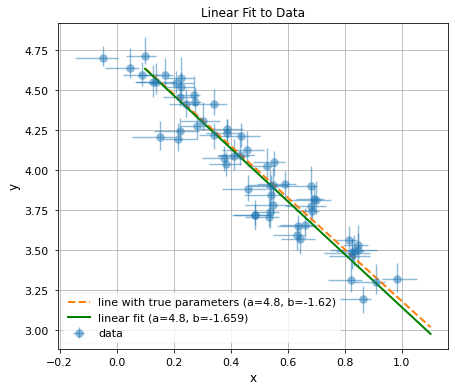

In [ ]:
# Create a figure
fig = plt.figure(figsize=(7, 6))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data (Choose either one of below)
#plt.plot(X, Y, 'o', label='data', ms=8.5, alpha=0.5)
plt.errorbar(X, Y, xerr=[sigma_X_low,sigma_X_up], yerr=[sigma_Y_low,sigma_Y_up], fmt='o', label='data', ms=8.5, alpha=0.5) # error bars show SD

# Plotting the line with true parameters
x_plot = np.linspace(0.1, 1.1, N_test)
y_true_plot = b_true*x_plot + a_true
plt.plot(x_plot, y_true_plot, '--', linewidth = 2.0, label=('line with true parameters (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ')'))
# Take geometric mean of sigmas
sigma_X = np.sqrt(np.multiply(sigma_X_low, sigma_X_up))
sigma_Y = np.sqrt(np.multiply(sigma_Y_low, sigma_Y_up))

# Function that calculates the parameters (using same notation with York)
def linear_fit(b_pred, iter): # start with a prediction of b and number of iterations
    for k in range(iter): 
        w_X = 1/np.power(sigma_X, 2) 
        w_Y = 1/np.power(sigma_Y, 2)
        W = np.multiply(w_X, w_Y)/(b_pred**2*w_Y + w_X)
        X_bar = np.sum(np.multiply(W, X))/np.sum(W)
        Y_bar = np.sum(np.multiply(W, Y))/np.sum(W)
        U = X - X_bar
        V = Y - Y_bar
        alpha_numerator = 0
        alpha_denominator = 0
        beta_numerator = 0
        beta_denominator = 0
        gamma_numerator = 0
        gamma_denominator = 0
        for i in range(N_test):
            alpha_numerator = alpha_numerator + W[i]**2*U[i]*V[i]/w_X[i]
            alpha_denominator = alpha_denominator + W[i]**2*U[i]**2/w_X[i]
            beta_numerator = beta_numerator + (W[i]**2*V[i]**2/w_X[i]) - W[i]*U[i]**2
            beta_denominator = beta_denominator + W[i]**2*U[i]**2/w_X[i]
            gamma_numerator = gamma_numerator + W[i]*U[i]*V[i]
            gamma_denominator = gamma_denominator + W[i]**2*U[i]**2/w_X[i]
        alpha = (2*alpha_numerator)/(3*alpha_denominator)
        beta = beta_numerator/(3*beta_denominator)
        gamma = -gamma_numerator/gamma_denominator
        b = []        
        for j in range(3): # there are three roots to be found
            b.append(alpha + 2*np.sqrt(alpha**2 - beta) * 
                     np.cos(1/3*(np.arccos((alpha**3 - 3*alpha*beta/2 + gamma/2)/
                                           (alpha**2 - beta)**(3/2)) + 2*np.pi*j)))
        b_pred = b[2] # root we are looking for is generally the third one (if solution is unusual check that)
        
    a_pred = Y_bar - b_pred*X_bar # calculate the intercept
    return a_pred, b_pred

# Defining predicted parameters
a_fit, b_fit = linear_fit(5, 4) # input a reasonable b prediction (small values can cause error)

# Plotting linear fit
y_plot = a_fit + b_fit*x_plot
plt.plot(x_plot, y_plot, linewidth = 2.0, color = 'green', label=('linear fit (a=' + str(np.round(a_fit, 3)) + 
                                                 ', b=' + str(np.round(b_fit, 3)) + ')'))


# Plot specs
plt.tick_params(labelsize=11)
plt.xlabel('x', fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.title('Linear Fit to Data', fontsize = 12)
plt.legend(fontsize = 11)
plt.grid()

# **Fitting a Model to Data with ANN**

## Define the ANN and its architecture

In [ ]:
model = keras.Sequential([
    layers.InputLayer(input_shape = (None, 6)),
    layers.LSTM(32, activation = 'tanh'),
    layers.Dense(2),
])

model.compile(loss = 'mean_squared_error', optimizer = tf.keras.optimizers.Adam(0.001))

##Download the trained model weights (If you run, you do not need training data and training process)

In [ ]:
!wget https://drive.google.com/uc?id=1hButCzuLf2VrPpvEmVB7H2mgco61kE58&export=download 
model.load_weights('uc?id=1hButCzuLf2VrPpvEmVB7H2mgco61kE58')

--2022-02-24 08:18:22--  https://drive.google.com/uc?id=1hButCzuLf2VrPpvEmVB7H2mgco61kE58
Resolving drive.google.com (drive.google.com)... 142.251.6.139, 142.251.6.101, 142.251.6.138, ...
Connecting to drive.google.com (drive.google.com)|142.251.6.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s5dv67r7j3rfqnj4dieq8smvt4aanpef/1645690650000/06440322669498725628/*/1hButCzuLf2VrPpvEmVB7H2mgco61kE58 [following]
--2022-02-24 08:18:22--  https://doc-0s-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s5dv67r7j3rfqnj4dieq8smvt4aanpef/1645690650000/06440322669498725628/*/1hButCzuLf2VrPpvEmVB7H2mgco61kE58
Resolving doc-0s-9s-docs.googleusercontent.com (doc-0s-9s-docs.googleusercontent.com)... 142.250.148.132, 2607:f8b0:4001:c54::84
Connecting to doc-0s-9s-docs.googleusercontent.com (doc-0s-9s-docs.googleusercontent.com)|142.250.148.132|:

##Training (if you downloaded the weights, you can skip)

### Create training and validation datasets

In [ ]:
J = 50000 # number of training models

a_train = np.linspace(-5.0, 5.0, J)
b_train = np.linspace(-5.0, 5.0, J)

# Shuffling the arrays to get random a and b pairs
np.random.shuffle(a_train)
np.random.shuffle(b_train)

In [ ]:
def data_set(N, a, b): 
  sigma_x_low = np.random.uniform(0.05, 0.10, N)
  sigma_x_up = np.random.uniform(0.02, 0.07, N) 
  sigma_y_low = np.random.uniform(0.05, 0.10, N) 
  sigma_y_up = np.random.uniform(0.06, 0.13, N)

  samples_x = np.random.randn(N)
  samples_y = np.random.randn(N)

  noise_x = np.zeros(N)
  noise_y = np.zeros(N)

  for i in range(N):
    if samples_x[i]>0:
      noise_x[i] = sigma_x_up[i]*samples_x[i]
    else:
      noise_x[i] = sigma_x_low[i]*samples_x[i]

    if samples_y[i]>0:
      noise_y[i] = sigma_y_up[i]*samples_y[i]
    else:
      noise_y[i] = sigma_y_low[i]*samples_y[i]

  x = np.linspace(0.1, 0.9, N) + noise_x
  y = a + b * (x-noise_x) + noise_y
  training_features = np.zeros((N, 6))
  training_labels = np.zeros((2))
  for i in range(N):
    for k in range(1):
      training_features[i,k] = x[i]
      training_features[i,k+1] = y[i]
      training_features[i,k+2] = sigma_x_low[i]
      training_features[i,k+3] = sigma_x_up[i]
      training_features[i,k+4] = sigma_y_low[i]
      training_features[i,k+5] = sigma_y_up[i]
  return(training_features)

In [ ]:
training_data = []
training_labels = np.zeros((J,2))

for j in range(J):
  N = np.random.randint(10,100)
  training_data.append(data_set(N, a_train[j], b_train[j]))
  training_labels[j,0] = a_train[j]
  training_labels[j,1] = b_train[j]

In [ ]:
# Manually split dataset into training and validation sets
from sklearn.model_selection import train_test_split

train_features, val_features, train_labels, val_labels = train_test_split(training_data,
                                                    training_labels,
                                                    test_size=0.20)
train_features = tf.ragged.constant(train_features) # define them as ragged tensor
val_features = tf.ragged.constant(val_features)

### Training process

In [ ]:
%%time
history = model.fit(
    train_features, train_labels,
    validation_data = (val_features, val_labels),
    verbose=1, epochs=75)

In [ ]:
def plot_loss(history):
    fig = plt.figure(figsize=(7, 6))
    plt.style.use('seaborn-paper')
    plt.rc('font', family='sans-serif')  
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.05])
    plt.xlabel('Epoch', fontsize = 12)
    plt.ylabel('Error', fontsize = 12)
    plt.legend()
    plt.grid(True)
    plt.legend(fontsize = 11)
plot_loss(history)

## Make prediction

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 5,058
Trainable params: 5,058
Non-trainable params: 0
_________________________________________________________________


In [ ]:
main = np.zeros((1, N_test, 6))

for i in range(N_test):
    main[0,i,0] = X[i]
    main[0,i,1] = Y[i]
    main[0,i,2] = sigma_X_low[i]
    main[0,i,3] = sigma_X_up[i]
    main[0,i,4] = sigma_Y_low[i]
    main[0,i,5] = sigma_Y_up[i]

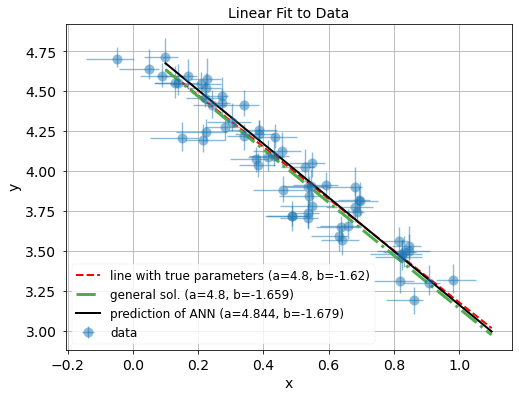

In [ ]:
# Create a figure
fig = plt.figure(figsize=(8, 6))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

# Plotting data (Choose either one of below)
#plt.plot(X, Y, 'o', label='data', ms=18.5, alpha=0.3)
plt.errorbar(X, Y, xerr=[sigma_X_low, sigma_X_up], yerr=[sigma_Y_low, sigma_Y_up], fmt='o', label='data', ms=10.0, alpha=0.5) # error bars show SD

# Plotting the line with true parameters
plt.plot(x_plot, y_true_plot, '--', linewidth = 2.0, label=('line with true parameters (a=' + str(a_true) +
                                                            ', b=' + str(b_true) + ')'), color = 'red')

# Plotting linear fit
plt.plot(x_plot, y_plot, '-.', linewidth = 3, label=('general sol. (a=' + str(np.round(a_fit, 3)) + 
                                                 ', b=' + str(np.round(b_fit, 3)) + ')'), color = '#4daf4a')

a_fit_ANN = model.predict(main)[0,0]
b_fit_ANN = model.predict(main)[0,1]

# Plotting predictions of ANN
y_ANN = a_fit_ANN + b_fit_ANN*x_plot
plt.plot(x_plot, y_ANN, linewidth = 2.0, label = ('prediction of ANN (a=' + str(np.round(a_fit_ANN, 3)) + ', b=' + str(np.round(b_fit_ANN, 3)) + ')'), color = 'black')

# Plot specs
plt.tick_params(labelsize= 14)
plt.xlabel('x', fontsize = 14)
plt.ylabel('y', fontsize = 14)
plt.title('Linear Fit to Data', fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()

##Triple plots

In [ ]:
# Choose parameters
true_params = np.zeros([3,2])

# True parameters of the models
true_params[0,0] = 0.4
true_params[0,1] = -1.9

true_params[1,0] = -2.8
true_params[1,1] = 0.9

true_params[2,0] = 1.8
true_params[2,1] = 2.1

data_point_nums = [25,45,65] # number of data points

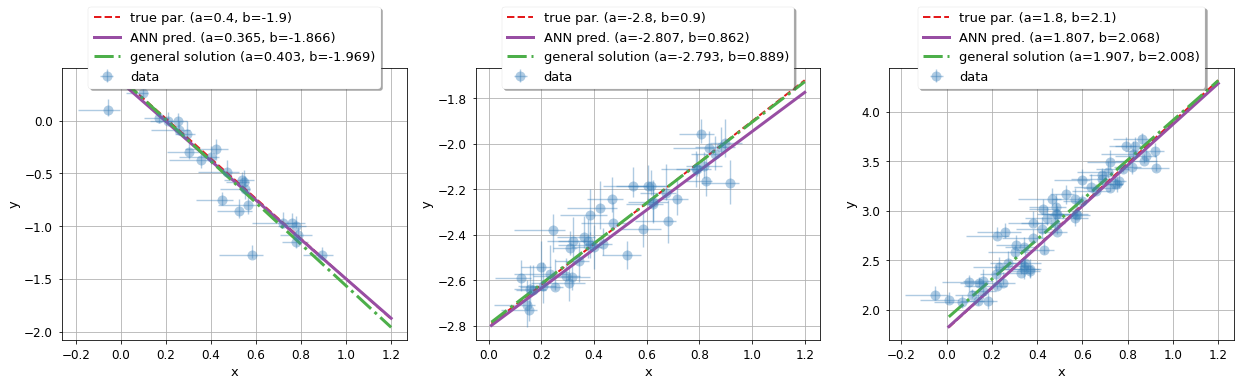

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize = (21,5))
plt.style.use('seaborn-paper')
plt.rc('font', family='sans-serif')

def triple(a, b, num, N):
  sigma_X_low = np.random.uniform(0.05, 0.15, N) # sample x coordinate sigmas from uniform distribution
  sigma_X_up = np.random.uniform(0.02, 0.07, N) # sample x coordinate sigmas from uniform distribution
  sigma_Y_low = np.random.uniform(0.01, 0.10, N) # sample y coordinate sigmas from uniform distribution
  sigma_Y_up = np.random.uniform(0.06, 0.13, N) # sample y coordinate sigmas from uniform distribution

  samples_x = np.random.randn(N)
  samples_y = np.random.randn(N)

  noise_X = np.zeros(N)
  noise_Y = np.zeros(N)

  for i in range(N):
    if samples_x[i]>0:
      noise_X[i] = sigma_X_up[i]*samples_x[i]
    else:
      noise_X[i] = sigma_X_low[i]*samples_x[i]

    if samples_y[i]>0:
      noise_Y[i] = sigma_Y_up[i]*samples_y[i]
    else:
      noise_Y[i] = sigma_Y_low[i]*samples_y[i]

    X = np.linspace(0.1, 0.9, N) + noise_X # observed X points
    Y = Y = b*(X-noise_X) + a + noise_Y # observed Y points

    data = np.zeros((1, N, 6))
    for i in range(N):
      data[0,i,0] = X[i]
      data[0,i,1] = Y[i]
      data[0,i,2] = sigma_X_low[i]
      data[0,i,3] = sigma_X_up[i]
      data[0,i,4] = sigma_Y_low[i]
      data[0,i,5] = sigma_Y_up[i]

  x_plot = np.linspace(0.01, 1.2, N)
  y_true_plot = b*x_plot + a

  a_ANN = model.predict(data)[0,0]
  b_ANN = model.predict(data)[0,1]
  y_ANN = a_ANN + b_ANN*x_plot

  #Find geometric mean of sigmas to use general solution
  sigma_X = np.sqrt(np.multiply(sigma_X_low, sigma_X_up))
  sigma_Y = np.sqrt(np.multiply(sigma_Y_low, sigma_Y_up))

  #Function of general solution
  def linear_fit(b_pred, iter): # start with a prediction of b and number of iterations
    for k in range(iter): 
        w_X = 1/np.power(sigma_X, 2) 
        w_Y = 1/np.power(sigma_Y, 2) 
        W = np.multiply(w_X, w_Y)/(b_pred**2*w_Y + w_X)
        X_bar = np.sum(np.multiply(W, X))/np.sum(W)
        Y_bar = np.sum(np.multiply(W, Y))/np.sum(W)
        U = X - X_bar
        V = Y - Y_bar
        alpha_numerator = 0
        alpha_denominator = 0
        beta_numerator = 0
        beta_denominator = 0
        gamma_numerator = 0
        gamma_denominator = 0
        for i in range(N):
            alpha_numerator = alpha_numerator + W[i]**2*U[i]*V[i]/w_X[i]
            alpha_denominator = alpha_denominator + W[i]**2*U[i]**2/w_X[i]
            beta_numerator = beta_numerator + (W[i]**2*V[i]**2/w_X[i]) - W[i]*U[i]**2
            beta_denominator = beta_denominator + W[i]**2*U[i]**2/w_X[i]
            gamma_numerator = gamma_numerator + W[i]*U[i]*V[i]
            gamma_denominator = gamma_denominator + W[i]**2*U[i]**2/w_X[i]
        alpha = (2*alpha_numerator)/(3*alpha_denominator)
        beta = beta_numerator/(3*beta_denominator)
        gamma = -gamma_numerator/gamma_denominator
        b = []        
        for j in range(3): # there are three roots to be found
            b.append(alpha + 2*np.sqrt(alpha**2 - beta) * 
                     np.cos(1/3*(np.arccos((alpha**3 - 3*alpha*beta/2 + gamma/2)/
                                           (alpha**2 - beta)**(3/2)) + 2*np.pi*j)))
        b_pred = b[2] # root we are looking for is generally the third one (if solution is unusual check that)
        
    a_pred = Y_bar - b_pred*X_bar # calculate the intercept
    return a_pred, b_pred

  #Plot general solution
  a_fit, b_fit = linear_fit(5, 4)
  y_plot = a_fit + b_fit*x_plot
  

  axs[num].errorbar(X, Y, xerr=[sigma_X_low,sigma_X_up], yerr=[sigma_Y_low,sigma_Y_up], fmt='o', label='data', ms=10.0, alpha=0.4, color = '#377eb8') # error bars show SD
  axs[num].plot(x_plot, y_true_plot, '--', linewidth = 2, label=('true par. (a=' + str(a) +
                                                                       ', b=' + str(b) +  ')' ), color = '#e41a1c')
  axs[num].plot(x_plot, y_ANN, linewidth = 3, label = ('ANN pred. (a=' + str(np.round(a_ANN, 3)) +
                                                          ', b=' + str(np.round(b_ANN, 3)) + ')'), color = '#984ea3')
  axs[num].plot(x_plot, y_plot, '-.', linewidth = 3, label=('general solution (a=' + str(np.round(a_fit, 3)) + 
                                                            ', b=' + str(np.round(b_fit, 3)) + ')'), color = '#4daf4a')
  
  axs[num].set_xlabel('x', fontsize = 13)
  axs[num].set_ylabel('y', fontsize = 13)

  axs[num].tick_params(labelsize=12)
  axs[num].legend(fontsize = 13, ncol=1, shadow=True, fancybox=True, loc='lower center', bbox_to_anchor=(0.5, 0.9))
  axs[num].grid()
  return()

for i in range(3):
  n = data_point_nums[i]
  triple(true_params[i,0], true_params[i,1], i, n)

In [ ]:
#model.save_weights('asymmetric_new.h5')

##**Below code is not updated!!!**




## Parameter variances
Create lots of datasets having the same true parameters but with different $x$, $y$ and error values. Then make predictions for each one. After that, look at the distributions of these predictions.

In [ ]:
def quality_data(N):
    noise_X = np.multiply(sigma_X, np.random.lognormal(size=N)) # error on x data (normally distributed)
    noise_Y = np.multiply(sigma_Y, np.random.lognormal(size=N)) # error on y data (normally distributed)
 
    # True parameters of the model which will be used to generate data
    a_true = a_fit_ANN
    b_true = b_fit_ANN

    X = np.linspace(0.1, 0.9, N) + noise_X # observed X points
    Y = b_true*(X-noise_X) + a_true + noise_Y
    main = np.zeros((1, N, 4))

    for i in range(N):
        main[0,i,0] = X[i]
        main[0,i,1] = Y[i]
        main[0,i,2] = sigma_X[i]
        main[0,i,3] = sigma_Y[i]
    return main, a_true, b_true

a_qual = []
b_qual = []

for i in range(5000):
    n = N_test
    pred = model.predict(quality_data(n)[0])
    a_qual.append(pred[0,0])
    b_qual.append(pred[0,1])
    

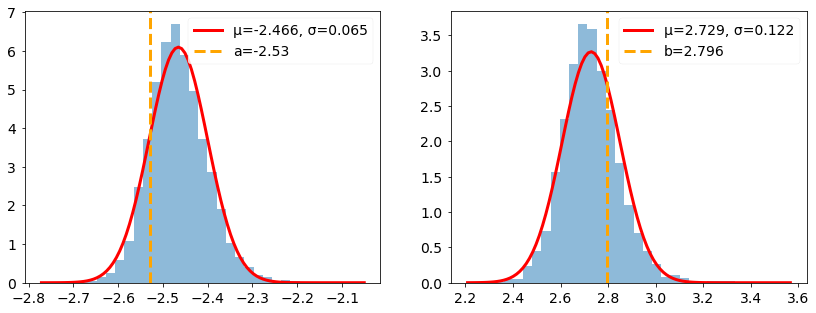

In [ ]:
import scipy
from scipy import stats

fig, axs = plt.subplots(1, 2, figsize=(14,5))

_, bins_a, _ = axs[0].hist(a_qual, 35, density = True, alpha=0.5)
sigma_a = np.std(a_qual)
mu_a = np.mean(a_qual)
a_x_axis_gauss = np.linspace(bins_a[0], bins_a[-1], 100)
best_fit_line_a = scipy.stats.norm.pdf(a_x_axis_gauss, mu_a, sigma_a)
axs[0].plot(a_x_axis_gauss, best_fit_line_a, color = 'red', label = 
         ('\u03BC=' + str(np.round(mu_a, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_a, 3))), linewidth = 3.0)
axs[0].axvline(a_fit_ANN, linestyle="--", color="orange", linewidth = 3.0, 
            label = 'a=' + str(np.round(a_fit_ANN, 3)))
axs[0].legend(fontsize = 14)
axs[0].tick_params(labelsize = 14)

_, bins_b, _ = axs[1].hist(b_qual, 35, density=True, alpha=0.5)
sigma_b = np.std(b_qual)
mu_b = np.mean(b_qual)
b_x_axis_gauss = np.linspace(bins_b[0], bins_b[-1], 100)
best_fit_line_b = scipy.stats.norm.pdf(b_x_axis_gauss, mu_b, sigma_b)
axs[1].plot(b_x_axis_gauss, best_fit_line_b, color = 'red', label = 
         ('\u03BC=' + str(np.round(mu_b, 3)) + ', ' + '\u03C3=' + str(np.round(sigma_b, 3))), linewidth = 3.0)
axs[1].axvline(b_fit_ANN, linestyle="--", 
            color="orange", linewidth = 3.0, label = 'b=' + str(np.round(b_fit_ANN, 3)))
axs[1].legend(fontsize = 14)
axs[1].tick_params(labelsize=14)

plt.show()